In [2]:
import os
import pyspark 
from pyspark.sql import SparkSession
import sys

In [2]:
!pip install findspark

In [2]:
import findspark
findspark.init() 

In [3]:
spark = SparkSession.builder.appName('LinearReg').getOrCreate()

In [4]:
df = spark.read.parquet('cleaned_listings.parquet')


In [5]:
print(df.columns)

['id', 'name', 'summary', 'longitude', 'latitude', 'space', 'description', 'instant_bookable', 'neighborhood_overview', 'neighbourhood_cleansed', 'host_id', 'host_name', 'host_since', 'host_response_time', 'street', 'zipcode', 'review_scores_rating', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'reviews_per_month', 'amenities', 'cancellation_policy', 'number_of_reviews', 'price']


In [6]:
new_df=df[['room_type','property_type','bedrooms','amenities','number_of_reviews', 'price']]

In [7]:
print(new_df.columns)

['room_type', 'property_type', 'bedrooms', 'amenities', 'number_of_reviews', 'price']


In [8]:
new_df.show(2,truncate=False)

+---------------+-------------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+-----+
|room_type      |property_type|bedrooms|amenities                                                                                                                                                                                                                                          |number_of_reviews|price|
+---------------+-------------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+-----+
|Entire home/apt|Apartment    |1.0     |{TV,"Cable TV",Internet,"Wireless

In [9]:
#Encode Amenities
from pyspark.sql.functions import col

new_df.groupBy('amenities').count().orderBy('count', ascending=False).show()


+--------------------+-----+
|           amenities|count|
+--------------------+-----+
|                  {}|   22|
|{Internet,"Wirele...|   11|
|{TV,"Cable TV",In...|   10|
|{TV,"Cable TV",In...|    6|
|{TV,Internet,"Wir...|    6|
|{Internet,"Wirele...|    6|
|{TV,"Cable TV",In...|    6|
|{TV,Internet,"Wir...|    6|
|{TV,"Cable TV",In...|    5|
|{TV,Internet,"Wir...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,Internet,"Wir...|    5|
|{Internet,"Wirele...|    5|
|{TV,"Cable TV",In...|    5|
|{Internet,"Wirele...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,Internet,"Wir...|    4|
|{TV,"Cable TV",In...|    4|
+--------------------+-----+
only showing top 20 rows



In [10]:
from pyspark.sql.functions import regexp_replace, split

# Create a set of all possible amenities
amenities_set = (
    new_df
    .select("amenities")
    .rdd
    .flatMap(lambda row: row.amenities.replace('{', '').replace('}', '').replace('"', '').split(','))
    .map(lambda amenity: amenity.strip())
    .distinct()
    .collect()
)

In [11]:
# Splitting and creating dedicated columns for each amenity
for amenity in amenities_set:
    new_df = new_df.withColumn(amenity, col("amenities").contains(amenity).cast("int"))


In [12]:
# Drop the original 'amenities' column
new_df = new_df.drop("amenities")

In [13]:
print(new_df.columns)

['room_type', 'property_type', 'bedrooms', 'number_of_reviews', 'price', 'TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible', 'Gym', '', 'Lock on Bedroom Door', 'Pool', 'Other pet(s)', 'Smoking Allowed', 'Doorman', 'Washer / Dryer']


In [14]:
new_df.show(1,truncate=False)

+---------------+-------------+--------+-----------------+-----+---+--------+--------+-----------------+----------------+-------+-------+-------------------+------+-----+------------------------+------------------------+--------------+------------------------+-------------+-----------+-----------------+----------+------------+--------------------------+------+------+-------+----------------+-------+---------+----------------+-------+----------+----+-------------------------+-------------------+--------------------+---------------------+---+---+--------------------+----+------------+---------------+-------+--------------+
|room_type      |property_type|bedrooms|number_of_reviews|price|TV |Cable TV|Internet|Wireless Internet|Air Conditioning|Kitchen|Heating|Family/Kid Friendly|Washer|Dryer|Free Parking on Premises|Buzzer/Wireless Intercom|Smoke Detector|Carbon Monoxide Detector|First Aid Kit|Safety Card|Fire Extinguisher|Essentials|Pets Allowed|Pets live on this property|Dog(s)|Cat(s)|Ho

In [15]:
new_df.groupBy('room_type').count().orderBy('count', ascending=False).show()


+---------------+-----+
|      room_type|count|
+---------------+-----+
|Entire home/apt| 1818|
|   Private room|  950|
|    Shared room|   92|
+---------------+-----+



In [16]:
#Encode room type
from pyspark.sql.functions import when

# List of distinct room types
room_types = ['Entire home/apt', 'Private room', 'Shared room']

# Loop through each room type and create a new column for each
for room_type in room_types:
    new_df = new_df.withColumn(room_type.replace(" ", "_").lower(), when(col("room_type") == room_type, 1).otherwise(0))

# Drop the original 'room_type' column
new_df = new_df.drop("room_type")


In [17]:
print(new_df.columns)

['property_type', 'bedrooms', 'number_of_reviews', 'price', 'TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible', 'Gym', '', 'Lock on Bedroom Door', 'Pool', 'Other pet(s)', 'Smoking Allowed', 'Doorman', 'Washer / Dryer', 'entire_home/apt', 'private_room', 'shared_room']


In [18]:
new_df.show(1,truncate=False)

+-------------+--------+-----------------+-----+---+--------+--------+-----------------+----------------+-------+-------+-------------------+------+-----+------------------------+------------------------+--------------+------------------------+-------------+-----------+-----------------+----------+------------+--------------------------+------+------+-------+----------------+-------+---------+----------------+-------+----------+----+-------------------------+-------------------+--------------------+---------------------+---+---+--------------------+----+------------+---------------+-------+--------------+---------------+------------+-----------+
|property_type|bedrooms|number_of_reviews|price|TV |Cable TV|Internet|Wireless Internet|Air Conditioning|Kitchen|Heating|Family/Kid Friendly|Washer|Dryer|Free Parking on Premises|Buzzer/Wireless Intercom|Smoke Detector|Carbon Monoxide Detector|First Aid Kit|Safety Card|Fire Extinguisher|Essentials|Pets Allowed|Pets live on this property|Dog(s)|

In [19]:
new_df.groupBy('property_type').count().orderBy('count', ascending=False).show()


+---------------+-----+
|  property_type|count|
+---------------+-----+
|          House| 1408|
|      Apartment| 1204|
|      Townhouse|   80|
|    Condominium|   68|
|Bed & Breakfast|   26|
|           Loft|   22|
|          Cabin|   17|
|          Other|   13|
|      Camper/RV|    8|
|           Boat|    5|
|           Tent|    4|
|       Bungalow|    2|
|      Treehouse|    1|
|           Dorm|    1|
|         Chalet|    1|
+---------------+-----+



In [20]:
# Encode property_type
from pyspark.sql.functions import when

# List of distinct property types
property_types = ['House', 'Apartment', 'Townhouse', 'Condominium', 'Bed & Breakfast',
                  'Loft', 'Cabin', 'Other', 'Camper/RV', 'Boat', 'Tent', 'Bungalow',
                  'Treehouse', 'Dorm', 'Chalet']

# Loop through each property type and create a new column for each
for property_type in property_types:
    new_df = new_df.withColumn(property_type.replace(" ", "_").lower(), when(col("property_type") == property_type, 1).otherwise(0))

# Drop the original 'property_type' column
new_df = new_df.drop("property_type")


In [21]:
print(new_df.columns)

['bedrooms', 'number_of_reviews', 'price', 'TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible', 'Gym', '', 'Lock on Bedroom Door', 'Pool', 'Other pet(s)', 'Smoking Allowed', 'Doorman', 'Washer / Dryer', 'entire_home/apt', 'private_room', 'shared_room', 'house', 'apartment', 'townhouse', 'condominium', 'bed_&_breakfast', 'loft', 'cabin', 'other', 'camper/rv', 'boat', 'tent', 'bungalow', 'treehouse', 'dorm', 'chalet']


In [22]:
new_df.show(1,truncate=False)

+--------+-----------------+-----+---+--------+--------+-----------------+----------------+-------+-------+-------------------+------+-----+------------------------+------------------------+--------------+------------------------+-------------+-----------+-----------------+----------+------------+--------------------------+------+------+-------+----------------+-------+---------+----------------+-------+----------+----+-------------------------+-------------------+--------------------+---------------------+---+---+--------------------+----+------------+---------------+-------+--------------+---------------+------------+-----------+-----+---------+---------+-----------+---------------+----+-----+-----+---------+----+----+--------+---------+----+------+
|bedrooms|number_of_reviews|price|TV |Cable TV|Internet|Wireless Internet|Air Conditioning|Kitchen|Heating|Family/Kid Friendly|Washer|Dryer|Free Parking on Premises|Buzzer/Wireless Intercom|Smoke Detector|Carbon Monoxide Detector|First Ai

In [23]:
# Split the data
from pyspark.sql.functions import rand
# Define the split ratios
train_ratio = 0.8
test_ratio = 0.2

# Split the DataFrame into train and test
train_df, test_df = new_df.randomSplit([train_ratio, test_ratio], seed=42)

# Show the number of rows in each split
print("Number of rows in df:",new_df.count())
print("Number of rows in train set:", train_df.count())
print("Number of rows in test set:", test_df.count())

Number of rows in df: 2860
Number of rows in train set: 2337
Number of rows in test set: 523


In [24]:
# Get the index of 'price' column
price_index = new_df.columns.index('price')
print("Index of 'price' column:", price_index)

Index of 'price' column: 2


In [25]:
price_column_index = 2
# Define a function to extract features and label from each row
def extract_features_label(row, price_column_index):
    features = row[:price_column_index] + row[price_column_index+1:]  # Extract all columns except the 'price' column
    label = row[price_column_index]  # Extract the 'price' column
    return (features, label)
transformed_rdd = train_df.rdd.map(lambda row: extract_features_label(row, price_column_index))


In [26]:
print(transformed_rdd.first())

((1.0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 22.0)


In [85]:
import numpy as np
num_features = len(transformed_rdd.first()[0])
print("num_features: "+ str(num_features))
weights = np.random.rand(num_features)


num_features: 62


In [86]:
# Define the Hypothesis Function
def hypothesis(x, weights):
    print(x)
    return np.dot(x, weights)

In [87]:
# Define the Cost Function
def cost_function(data, weights):
    squared_errors = data.map(lambda point: (hypothesis(point[0], weights) - point[1]) ** 2)
    return squared_errors.reduce(lambda x, y: x + y) / (2 * 2337)


In [88]:
# Gradient Descent
def gradient_descent(data, weights, learning_rate):
    gradients = data.map(lambda point: np.multiply(hypothesis(point[0], weights) - point[1], point[0]))
    gradient_sum = gradients.reduce(lambda x, y: np.add(x, y))
    return np.subtract(weights, np.multiply(learning_rate /2337, gradient_sum))


In [89]:
# Hyperparameters
learning_rate = 0.0008
num_iterations = 500

In [90]:
# Training loop
train_no=1
cost_values=[]
for _ in range(num_iterations):
    print("train no: "+str(train_no))
    weights = gradient_descent(transformed_rdd, weights, learning_rate)
    cost = cost_function(transformed_rdd, weights)
    cost_values.append(cost)
    train_no+=1
    print("Cost:", cost)

train no: 1
Cost: 10031.591076709685
train no: 2
Cost: 9747.980566543001
train no: 3
Cost: 9547.408393751224
train no: 4
Cost: 9392.747568526249
train no: 5
Cost: 9263.793325996357
train no: 6
Cost: 9149.544707037727
train no: 7
Cost: 9044.00668615295
train no: 8
Cost: 8943.90704313983
train no: 9
Cost: 8847.454619464856
train no: 10
Cost: 8753.663959628993
train no: 11
Cost: 8661.987996220187
train no: 12
Cost: 8572.118272818836
train no: 13
Cost: 8483.876286898032
train no: 14
Cost: 8397.154390820011
train no: 15
Cost: 8311.88364637771
train no: 16
Cost: 8228.016338790325
train no: 17
Cost: 8145.516463681659
train no: 18
Cost: 8064.354550424378
train no: 19
Cost: 7984.504843977774
train no: 20
Cost: 7905.943769499658
train no: 21
Cost: 7828.649094672675
train no: 22
Cost: 7752.599471544213
train no: 23
Cost: 7677.774184817068
train no: 24
Cost: 7604.153012464981
train no: 25
Cost: 7531.716147480178
train no: 26
Cost: 7460.444152909116
train no: 27
Cost: 7390.317935032026
train no: 28

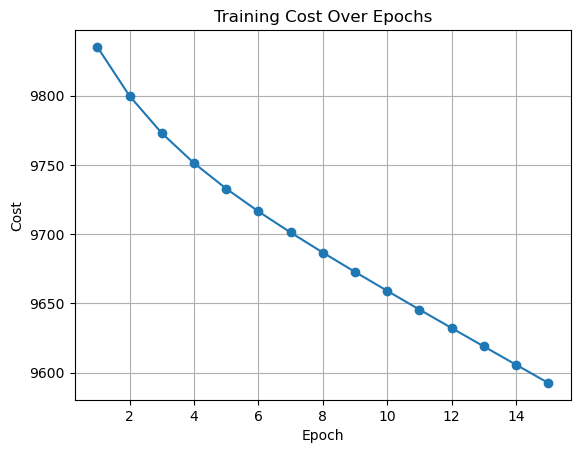

In [91]:
# Test convergence
import matplotlib.pyplot as plt
# Assuming cost_values is a list containing cost values at each epoch
cost_values = [9835.27887626617, 9799.87676723162, 9772.990264272146, 9751.332654211788, 9732.889819803166, 9716.42748976651, 9701.18928194726, 9686.711664367487, 9672.710563483419, 9659.011877802215, 9645.508896673498, 9632.13620655341, 9618.853700780848, 9605.636780779096, 9592.470351358672]

# Plotting the cost values
plt.plot(range(1, len(cost_values) + 1), cost_values, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Training Cost Over Epochs')
plt.grid(True)
plt.show()

In [92]:
test_rdd = test_df.rdd.map(lambda row: extract_features_label(row, price_column_index))

In [93]:
# # Define a function to make predictions
# def predict(features, weights):
#     return np.dot(features, weights)

# # Make predictions on a new set of features
# def make_predictions(data, weights):
#     predictions = data.map(lambda point: (point[0], predict(point[0], weights)))
#     return predictions

# # Use the trained weights to make predictions on the test set
# predictions = make_predictions(test_rdd, weights)

# # Optional: Collect the predictions as a list
# predictions_list = predictions.collect()

# # # Print the predictions (if needed)
# # for features, prediction in predictions_list:
# #     # print("Features:", features)
# #     print("Predicted Price:", prediction)
# Calculate predictions for the test dataset
predictions = test_rdd.map(lambda point: (hypothesis(point[0], weights), point[1]))
predictions_list = predictions.collect()
for prediction,label in predictions_list:
    print("prediction: ",prediction)
    print("label: ",label)
    print("======================================")


prediction:  93.0120089946551
label:  30.0
prediction:  78.88572994172472
label:  39.0
prediction:  104.95108419914624
label:  40.0
prediction:  99.85021571740413
label:  40.0
prediction:  93.6927728975473
label:  49.0
prediction:  105.07751938592978
label:  50.0
prediction:  85.88378260728538
label:  53.0
prediction:  87.55587901115061
label:  59.0
prediction:  97.06778577612482
label:  69.0
prediction:  136.0027503189158
label:  69.0
prediction:  77.78754910204172
label:  70.0
prediction:  145.9201397446696
label:  70.0
prediction:  126.90289551050103
label:  72.0
prediction:  130.3538776619048
label:  75.0
prediction:  94.92910620587935
label:  80.0
prediction:  110.24694023792253
label:  85.0
prediction:  130.32646283799082
label:  95.0
prediction:  96.77882734620421
label:  115.0
prediction:  128.011072921397
label:  125.0
prediction:  131.20232796921994
label:  130.0
prediction:  118.18251198049703
label:  130.0
prediction:  148.5992750667774
label:  135.0
prediction:  126.220147

In [94]:
import numpy as np

# Define a function to calculate Mean Absolute Error (MAE)
def calculate_mae(predictions):
    mae = np.mean([abs(pred[0] - pred[1]) for pred in predictions])
    return mae

# Define a function to calculate Mean Squared Error (MSE)
def calculate_mse(predictions):
    mse = np.mean([(pred[0] - pred[1]) ** 2 for pred in predictions])
    return mse

# Define a function to calculate Root Mean Squared Error (RMSE)
def calculate_rmse(predictions):
    mse = calculate_mse(predictions)
    rmse = np.sqrt(mse)
    return rmse


# Calculate evaluation metrics
mae = calculate_mae(predictions_list)
mse = calculate_mse(predictions_list)
rmse = calculate_rmse(predictions_list)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 49.228371743973454
Mean Squared Error (MSE): 6209.293319936464
Root Mean Squared Error (RMSE): 78.79906928344055


In [ ]:
# # Define a function to calculate Mean Absolute Error (MAE)
# def calculate_mae(predictions, actual_values):
#     mae = predictions.map(lambda pred: abs(pred[1] - actual_values[pred[0]]))
#     return mae.mean()

# # Define a function to calculate Mean Squared Error (MSE)
# def calculate_mse(predictions, actual_values):
#     mse = predictions.map(lambda pred: (pred[1] - actual_values[pred[0]]) ** 2)
#     return mse.mean()

# # Define a function to calculate Root Mean Squared Error (RMSE)
# def calculate_rmse(predictions, actual_values):
#     mse = calculate_mse(predictions, actual_values)
#     rmse = np.sqrt(mse)
#     return rmse


# # Calculate evaluation metrics
# mae = calculate_mae(predictions, actual_values_dict)
# mse = calculate_mse(predictions, actual_values_dict)
# rmse = calculate_rmse(predictions, actual_values_dict)

# print("Mean Absolute Error (MAE):", mae)
# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)


In [6]:
# # Get column names
# column_names = df.columns
# # # Identify categorical columns (replace with your actual list)
# categorical_cols = []  
# idx=0
# for feat in df.rdd.collect()[0]:
#     # print(feat)
#     if isinstance(feat, str):
#         categorical_cols.append(column_names[idx])   
#     idx+=1
# print("categorical columns:", categorical_cols)

categorical columns: ['name', 'summary', 'space', 'description', 'instant_bookable', 'neighborhood_overview', 'neighbourhood_cleansed', 'host_name', 'host_response_time', 'street', 'property_type', 'room_type', 'amenities', 'cancellation_policy']


In [7]:
# print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [13]:
# from pyspark.ml.feature import StringIndexer, OneHotEncoder
# from pyspark.sql.functions import col
# def parse_data(df):
#     """
#     Parse the given DataFrame by applying StringIndexer and OneHotEncoder to categorical columns.

#     Args:
#         df (DataFrame): Input DataFrame.

#     Returns:
#         DataFrame: Parsed DataFrame with features and label columns.
#     """
#     # Apply StringIndexer and OneHotEncoder to categorical columns
#     for col_name in categorical_cols:
#         string_indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index")
#         df = string_indexer.fit(df).transform(df)
#         encoder = OneHotEncoder(inputCols=[col_name + "_index"], outputCols=[col_name + "_encoded"])
#         df = encoder.fit(df).transform(df)

#     # Select only the features and label columns
#     selected_cols = [col(col_name + "_encoded") for col_name in categorical_cols] + \
#                     [col(col_name) for col_name in column_names if col_name not in categorical_cols]

#     # print("df label",df.columns[-1])
#     # Select the label column as the last column
#     # selected_cols.append(col(df.columns[-1]))

#     # Create a new DataFrame with selected columns
#     parsed_data = df.select(selected_cols)
   


#     return parsed_data,selected_cols


In [14]:
# parsed_data,new_columns = parse_data(df)
# parsed_data.show(2, truncate=False)
# print(parsed_data.columns)


+-------------------+------------------+------------------+-------------------+------------------------+-----------------------------+------------------------------+------------------+--------------------------+------------------+---------------------+-----------------+------------------+---------------------------+------+-------------------+------------------+-------+----------+-------+--------------------+------------+---------+--------+----+-----------------+-----------------+-----+
|name_encoded       |summary_encoded   |space_encoded     |description_encoded|instant_bookable_encoded|neighborhood_overview_encoded|neighbourhood_cleansed_encoded|host_name_encoded |host_response_time_encoded|street_encoded    |property_type_encoded|room_type_encoded|amenities_encoded |cancellation_policy_encoded|id    |longitude          |latitude          |host_id|host_since|zipcode|review_scores_rating|accommodates|bathrooms|bedrooms|beds|reviews_per_month|number_of_reviews|price|
+-----------------

In [15]:
# def map_to_features_label(row):
#     # Get all columns except the last one as features
#     features = tuple(row[:-1])
#     # Get the last column as label
#     label = row[-1]
#     return (features, label)

# # Assuming your RDD contains rows where each row is a list or tuple representing a record
# features_label_rdd = parsed_data.rdd.map(map_to_features_label)


In [27]:
# print(features_label_rdd.first())

((SparseVector(2847, {2448: 1.0}), SparseVector(2587, {0: 1.0}), SparseVector(2477, {867: 1.0}), SparseVector(2805, {1287: 1.0}), SparseVector(1, {0: 1.0}), SparseVector(1983, {0: 1.0}), SparseVector(86, {18: 1.0}), SparseVector(1195, {240: 1.0}), SparseVector(4, {1: 1.0}), SparseVector(1244, {443: 1.0}), SparseVector(14, {1: 1.0}), SparseVector(2, {0: 1.0}), SparseVector(2468, {48: 1.0}), SparseVector(2, {1: 1.0}), 241032, -122.37102519997764, 47.636289038357184, 956883, datetime.date(2011, 8, 11), 98119, 95.0, 4, 1.0, 1.0, 1.0, 4.07, 207), 85.0)


In [17]:
import numpy as np
num_features = len(features_label_rdd.first()[0])
print("num_features: "+ str(num_features))
weights = np.random.rand(num_features)


num_features: 27


In [18]:
print("weights: ",weights)

weights:  [0.87046856 0.23976199 0.66213714 0.63516609 0.06668356 0.71060495
 0.03810719 0.66848876 0.77808885 0.22765066 0.59193383 0.07102096
 0.18270704 0.90036144 0.84343172 0.55622916 0.26375011 0.2763589
 0.19233865 0.27871359 0.43218039 0.80314704 0.75291542 0.52609523
 0.71738962 0.84796832 0.11538921]


In [33]:
# # Define the Hypothesis Function
def hypothesis(x, weights):
#     x_dense = x.toArray()

#     print(x)
#     return np.dot(x, weights)
    # Convert each SparseVector to dense array and compute dot product individually
    dot_products = [np.dot(vec.toArray(), weights) for vec in x]
    # Sum the dot products to get the overall hypothesis value
    return np.sum(dot_products)

In [34]:
# Define the Cost Function
def cost_function(data, weights):
    squared_errors = data.map(lambda point: (hypothesis(point[0], weights) - point[1]) ** 2)
    return squared_errors.reduce(lambda x, y: x + y) / (2 * 3818)


In [35]:
# Gradient Descent
def gradient_descent(data, weights, learning_rate):
    gradients = data.map(lambda point: np.multiply(hypothesis(point[0], weights) - point[1], point[0]))
    print(gradients)
    gradient_sum = gradients.reduce(lambda x, y: np.add(x, y))
    return np.subtract(weights, np.multiply(learning_rate / 3818, gradient_sum))


In [36]:
# Hyperparameters
learning_rate = 0.01
num_iterations = 100

In [37]:
# Training loop
train_no=1
for _ in range(num_iterations):
    print("train no: "+str(train_no))
    weights = gradient_descent(features_label_rdd, weights, learning_rate)
    print("weights after train no:"+str(train_no) +" ,is :"+str(weights))
    cost = cost_function(features_label_rdd, weights)
    train_no+=1
    print("Cost:", cost)

train no: 1
PythonRDD[250] at RDD at PythonRDD.scala:53


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 93.0 failed 1 times, most recent failure: Lost task 0.0 in stage 93.0 (TID 65) (ebc14d848522 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/pyspark/rdd.py", line 1919, in func
    initial = next(iterator)
              ^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_171/326524951.py", line 3, in <lambda>
  File "/tmp/ipykernel_171/1833759935.py", line 8, in hypothesis
  File "/tmp/ipykernel_171/1833759935.py", line 8, in <listcomp>
  File "<__array_function__ internals>", line 200, in dot
ValueError: shapes (2847,) and (27,) not aligned: 2847 (dim 0) != 27 (dim 0)

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1046)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/pyspark/rdd.py", line 1919, in func
    initial = next(iterator)
              ^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_171/326524951.py", line 3, in <lambda>
  File "/tmp/ipykernel_171/1833759935.py", line 8, in hypothesis
  File "/tmp/ipykernel_171/1833759935.py", line 8, in <listcomp>
  File "<__array_function__ internals>", line 200, in dot
ValueError: shapes (2847,) and (27,) not aligned: 2847 (dim 0) != 27 (dim 0)

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1046)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [ ]:
# from pyspark.ml.feature import StringIndexer, OneHotEncoder
# from pyspark.sql import Row

# def parse_data_rdd(row, string_indexers, encoders):
#     # Apply StringIndexer and OneHotEncoder to categorical columns
#     for col_name, indexer, encoder in zip(categorical_cols, string_indexers, encoders):
#         row[col_name + "_index"] = indexer.transform([row[col_name]])[0]
#         row[col_name + "_encoded"] = encoder.transform([row[col_name + "_index"]])[0]
    
#     # Select only the features and label columns
#     selected_cols = [row[col_name + "_encoded"] for col_name in categorical_cols] + \
#                     [row[col_name] for col_name in column_names if col_name not in categorical_cols]
    
#     # Return the selected columns as a tuple
#     return tuple(selected_cols)

# # Initialize StringIndexer and OneHotEncoder objects
# string_indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index") for col_name in categorical_cols]
# encoders = [OneHotEncoder(inputCols=[col_name + "_index"], outputCols=[col_name + "_encoded"]) for col_name in categorical_cols]

# # Assuming your RDD contains dictionaries where keys are column names
# # and values are corresponding values for each row
# parsed_data_rdd = df.rdd.map(lambda row: parse_data_rdd(row, string_indexers, encoders))
# print(parsed_data_rdd.collect()[0])

In [22]:
# from pyspark.ml.feature import StringIndexer, OneHotEncoder
# from pyspark.sql.functions import col

# def parse_data(df):
#     # Apply StringIndexer and OneHotEncoder to categorical columns
#     for col_name in categorical_cols:
#         string_indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index")
#         df = string_indexer.fit(df).transform(df)
#         encoder = OneHotEncoder(inputCols=[col_name + "_index"], outputCols=[col_name + "_encoded"])
#         df = encoder.fit(df).transform(df)

#     # Select only the features and label columns
#     selected_cols = [col(col_name + "_encoded") for col_name in categorical_cols] + \
#                     [col(col_name) for col_name in column_names if col_name not in categorical_cols]
#     parsed_data = df.select(selected_cols)
   


#     return parsed_data,selected_cols
    

In [23]:
parsed_data,new_columns = parse_data(df)
parsed_data.show(2, truncate=False)

+-------------------+------------------+------------------+-------------------+------------------------+-----------------------------+------------------------------+------------------+--------------------------+------------------+---------------------+-----------------+------------------+---------------------------+------+-------------------+------------------+-------+----------+-------+--------------------+------------+---------+--------+----+-----------------+-----------------+-----+
|name_encoded       |summary_encoded   |space_encoded     |description_encoded|instant_bookable_encoded|neighborhood_overview_encoded|neighbourhood_cleansed_encoded|host_name_encoded |host_response_time_encoded|street_encoded    |property_type_encoded|room_type_encoded|amenities_encoded |cancellation_policy_encoded|id    |longitude          |latitude          |host_id|host_since|zipcode|review_scores_rating|accommodates|bathrooms|bedrooms|beds|reviews_per_month|number_of_reviews|price|
+-----------------